# Applied Similarity Learning: Signatures & Satellites

Welcome! So far, your journey with deep learning has likely involved building models that follow a linear path: data goes in one end, flows through a series of layers, and a single prediction comes out the other. This is a powerful and straightforward approach for many classification and regression tasks.

But what happens when the question is not "What is this?" but rather, "Are these two things similar?". This shift in perspective requires a different kind of architecture, one that excels at comparison rather than categorization.

In this lab, you will build and train a **Siamese Network**, a specialized architecture designed to learn a *similarity* function. Instead of a traditional classifier that learns to assign a label to a single input, a Siamese network learns to measure the "distance" between two or more inputs in a learned feature space. It achieves this by processing multiple inputs through an identical encoding network. This single, reused network ensures that all inputs are mapped to a consistent and comparable representation, creating an embedding space where similar items are pulled close together and dissimilar items are pushed far apart.

The flexibility of this approach makes it an invaluable tool for solving complex, real-world problems. To see this in action, you will apply this architecture to two completely different domains.

#### Use Case 1: Signature Verification

> You will first build a model to handle signature verification, a vital security task in settings like at a bank. The goal is to accurately determine if two signatures were written by the same person. A standard classifier struggles with this because it would need to be retrained for every new individual. Your Siamese network will instead learn the general characteristics of handwriting, enabling it to verify signatures even for people it has never seen during training. You will train this model using triplets of images: an anchor (the reference signature), a positive (another genuine one), and a negative (a forgery).
>
#### Use Case 2: Environmental Change Detection
>
> Next, you will showcase the model's versatility by adapting it for an environmental task. Instead of signatures, you will compare satellite images of the same location taken at different times. The goal is to detect significant changes in vegetation by analyzing "Before" and "After" image pairs. This application demonstrates how a model trained to understand similarity can be a powerful tool for monitoring our changing planet.

In this lab, you will:
* Build a custom `SiameseNetwork` class from the ground up.
* Prepare specialized datasets that provide image triplets and pairs for training.
* Train a model for signature verification using `TripletMarginLoss`.
* Adapt the model to detect environmental changes using a custom `WeightedContrastiveLoss`.
* Apply your trained models to perform predictions on new, unseen data.

Let's get started!

## Imports

In [1]:
import glob
import os
import random
from collections import defaultdict

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import helper_utils
import training_functions

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Use Case 1**: Signature *Verification*

Your first challenge is to tackle signature verification, an application with important security implications in settings such as banking. To do this, you will use a specially prepared version of the [Signature Verification_v5](https://universe.roboflow.com/signature-verification-online-and-offline/signature-verification_v5) dataset, which contains multiple genuine (**Real**) and forged (**Fake**) signatures for many individuals.

**How the Dataset Was Prepared by Original Authors**

The original authors performed extensive work to standardize and enrich the images by applying the significant modifications summarized below:

* **Pre-processing:**
    * **Auto-orientation** of pixel data (with EXIF-orientation stripping) to ensure all images have the correct upright orientation.
    * **Standard Resize** to 224x224 pixels (Stretch) for uniform model input.
    * **Conversion to Grayscale** (CRT phosphor) to help the model learn the fundamental shapes and strokes of the signatures.
* **Augmentation**
    * Random **rotation** between -15 and +15 degrees to mimic the natural tilt of a paper or scanner.
    * Random **brightness** adjustment between -25% and +25% and random **exposure** adjustment between -15% and +15% to simulate various lighting conditions.
    * Random Gaussian **blur** of up to 0.5 pixels to represent minor focus issues common with scanning hardware.
    
**How the Dataset Was Prepared for This Lab**

While the original dataset was well prepared, it stored signatures in bulk 'real' and 'fake' folders. For this lab, the data was meticulously reorganized to create a more powerful learning experience. Using machine learning clustering and subsequent human review, signatures were grouped into **52 unique individual profiles**.

You will train and validate your model on 51 of these profiles, reserving the final one to test the model's performance on a completely unseen individual. This "per person" organization provides the foundation for training an effective similarity based network.

As you explore the data, you may find images that appear miscategorized. This is not an error but a realistic simulation of a common industry challenge. Building models that are robust enough to handle this "data noise" is a fundamental skill for any AI professional.

* Run the next cells below to see a statistical overview of your dataset.

In [3]:
# Define the path to the root directory containing the signature dataset.
signature_data_dir = './Signature_Verification_v5_v11/'

Found 51 valid IDs.
   - Total Real Images: 979
   - Total Fake Images: 929



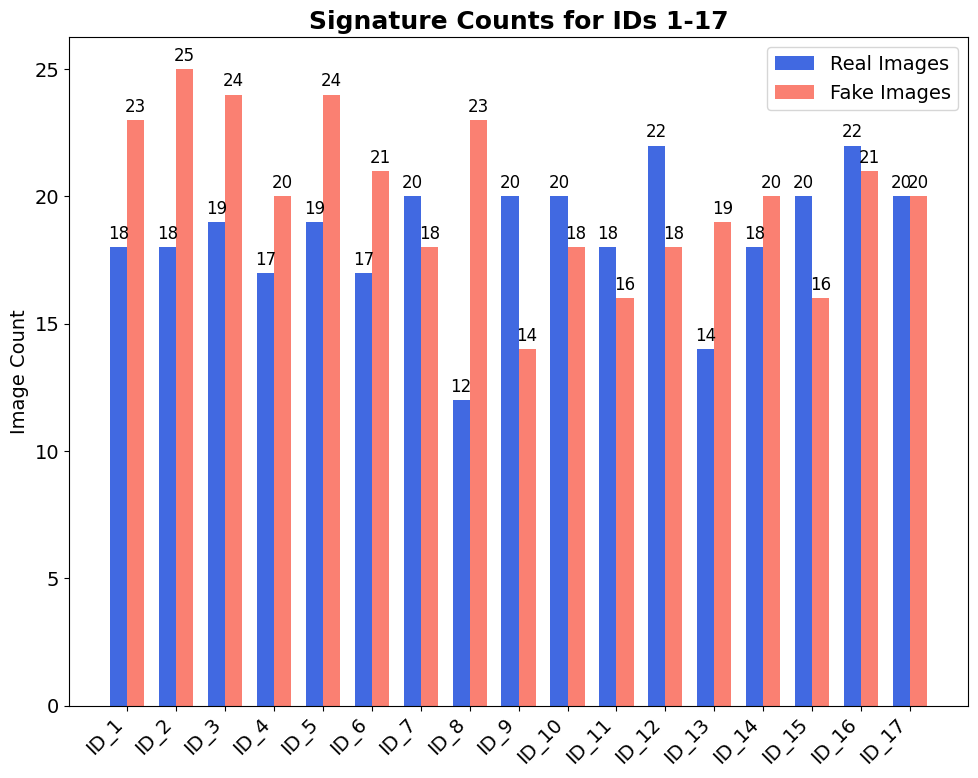

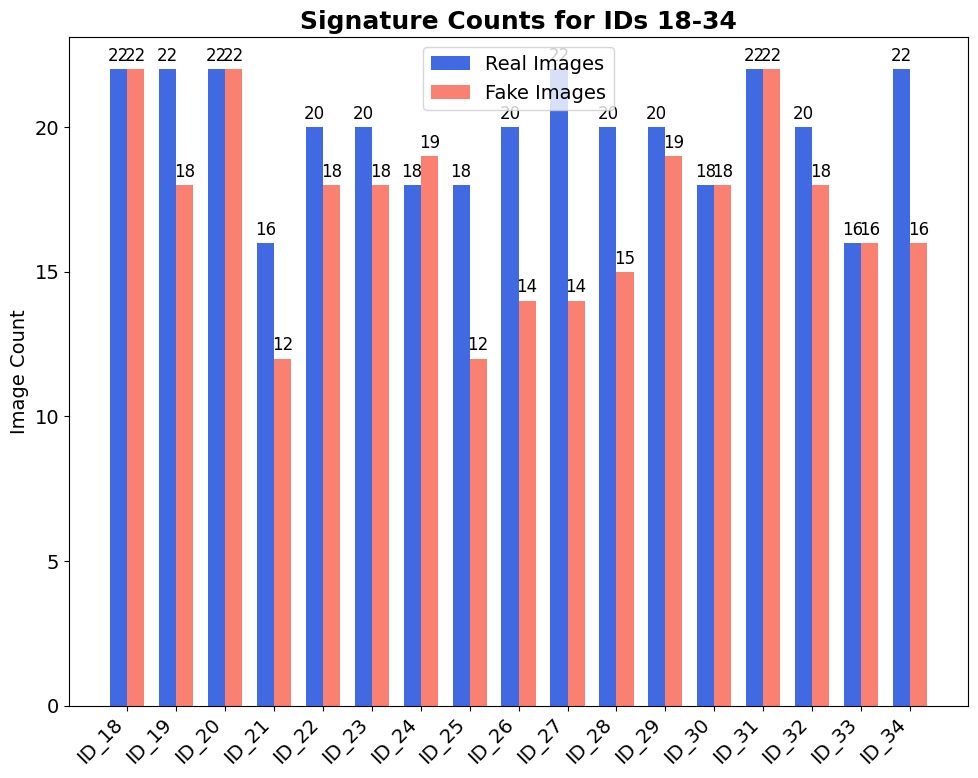

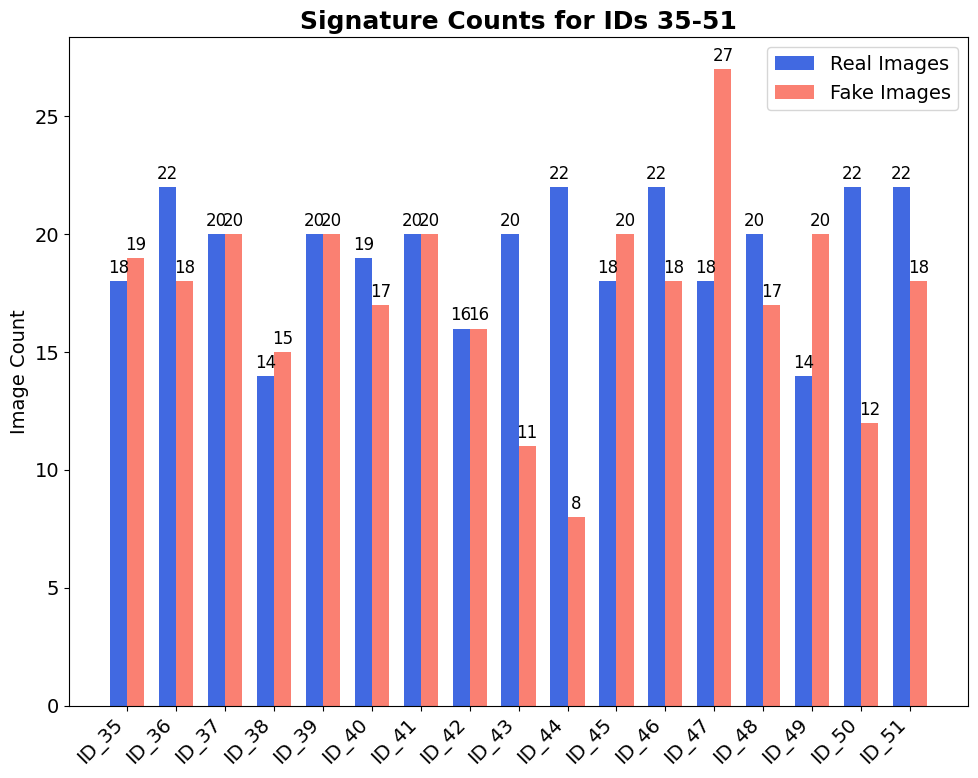

In [4]:
# Scan the data directory and display the statistical summary.
helper_utils.display_signature_dataset_summary(signature_data_dir)

* Run the cell below to see a side by side comparison of a "genuine" signature and a corresponding "forgery" for a randomly chosen individual.

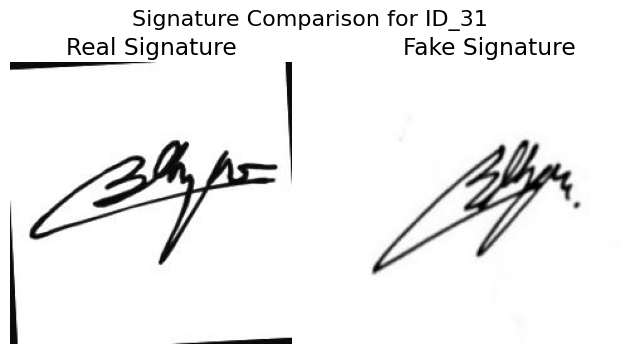

In [5]:
# Display a side-by-side comparison of a random real and fake signature from the dataset.
helper_utils.display_random_signature_pair(signature_data_dir)

### Building a Custom Triplet Dataset Class

This next step is a cornerstone of your model's success. Unlike traditional classifiers, a Siamese Network learns from **comparisons**. You will teach it to distinguish genuine signatures from forgeries by feeding it specially structured data packets called **triplets**. Each triplet is the essential learning unit for your model and contains three images:

* **Anchor**: A genuine signature from an individual. This is your baseline.
* **Positive**: A *different* genuine signature from the **same** individual.
* **Negative**: A forged signature of that **same** individual.

By training on these triplets, your model learns a specific objective: to minimize the distance between the **Anchor** and **Positive** while maximizing the distance between the **Anchor** and **Negative**. This process is how the network develops a nuanced understanding of an individual's unique handwriting.

To generate these triplets on the fly, the data must be organized predictably. The `SignatureTripletDataset` class is designed to work with the exact 'per person' directory structure shown below. This clean separation allows the class to efficiently sample genuine images for the **Anchor** and **Positive** roles and forged images for the **Negative**.

```
./Signature_Verification_v5_v11/
│
├── Real/
│   ├── ID_01/
│   │   ├── signature_real_1_1.jpg
│   │   ├── signature_real_1_2.jpg
│   │   └── ... (more real signatures)
│   │
│   └── ... (more individual folders)
│
└── Fake/
    ├── ID_01/
    │   ├── signature_fake_1_1.jpg
    │   └── ... (more fake signatures)
    │
    └── ... (more individual folders)
```

This class is the engine that connects the organized directory structure to the triplet concept your model needs. It's a standard PyTorch `Dataset` with a few implementations designed specifically for this task. Here's how its main components empower your training process:

* **`__init__(self, base_data_dir, ...)`**: 
> This is the constructor, which performs a **one-time** setup when you create the dataset object.
>    * It efficiently scans the entire `base_data_dir`, validates each individual's folder, and builds a `signature_map` that stores all valid file paths.
>    * The `triplets_per_user` argument you provide gives you direct control over the length of each training epoch.

* **`__len__(self)`**: 
> This method returns the "virtual" size of your dataset for an epoch.
>    * This size is calculated by multiplying the number of individuals by the `triplets_per_user` value. 
>        * The `triplets_per_user` acts like any other hyperparameter that you can tune to control the length and dynamics of each training epoch.

* **`__getitem__(self, index)`**: 
> This is the core of the data loading process, generating a new training triplet every time one is requested. A key aspect of its design is that it **intentionally ignores the `index` argument**. Instead of fetching a pre-defined item, it randomly selects an individual and then samples a unique combination of **Anchor**, **Positive**, and **Negative** images.
>    * This on-the-fly random sampling is a powerful feature: it ensures your model sees a massive variety of triplets, forcing it to learn the general characteristics of a person's handwriting rather than memorizing specific pairs.

* **`_load_image(self, path)`**: 
> This is a private helper method that robustly loads each image.
>    * It uses a context manager to ensure files are closed properly, preventing potential resource leaks during long training runs, and making the overall class more resilient.

In [6]:
class SignatureTripletDataset(Dataset):
    """
    A PyTorch Dataset for creating signature triplets for verification.

    This class scans a directory of real and fake signatures, organized by
    user ID, and generates triplets (anchor, positive, negative) on the fly
    for training a Siamese network with triplet loss.
    """
    
    def __init__(self, base_data_dir, triplets_per_user=100, transform=None):
        """
        Initializes the dataset by scanning the data directory and organizing file paths.
        
        Args:
            base_data_dir (str): The root directory of the signature dataset.
            triplets_per_user (int): The "virtual" number of triplets to generate
                                     per individual for one epoch.
            transform (callable, optional): PyTorch transforms to be applied to each image.
        """
        self.base_data_dir = base_data_dir
        self.triplets_per_user = triplets_per_user
        self.transform = transform
        # Build the map of all available image paths from the source directory.
        self.signature_map = self._create_signature_map()
        # Create the definitive list of individuals to be used in the dataset.
        self.user_ids = list(self.signature_map.keys())
        
        # Raise an error if the dataset directory is empty or improperly structured.
        if not self.user_ids:
            raise RuntimeError(f"No valid individuals found in {base_data_dir}. Check directory structure and image counts.")

    def _create_signature_map(self):
        """Scans the directory to build a map of individuals to their signature paths (one-time setup)."""
        # Define paths for real and fake signature directories.
        real_signatures_dir = os.path.join(self.base_data_dir, 'Real')
        fake_signatures_dir = os.path.join(self.base_data_dir, 'Fake')
        signature_map = defaultdict(lambda: {'real': [], 'fake': []})

        # Validate that the 'Real' signatures directory exists.
        if not os.path.isdir(real_signatures_dir):
            raise FileNotFoundError(f"Error: Directory not found at {real_signatures_dir}")

        # Validate that the 'Fake' signatures directory exists.
        if not os.path.isdir(fake_signatures_dir):
            raise FileNotFoundError(f"Error: Directory not found at {fake_signatures_dir}")

        # Iterate through each user ID directory.
        all_ids = sorted(os.listdir(real_signatures_dir))
        for user_id in all_ids:
            if user_id.startswith('ID_'):
                # Find all real and fake signature images for the current user.
                real_images = glob.glob(os.path.join(real_signatures_dir, user_id, '*.jpg'))
                fake_images = glob.glob(os.path.join(fake_signatures_dir, user_id, '*.jpg'))
                
                # Only include individuals with enough images to create a valid triplet.
                if len(real_images) >= 2 and len(fake_images) >= 1:
                    signature_map[user_id]['real'] = real_images
                    signature_map[user_id]['fake'] = fake_images
                    
        return signature_map

    def __len__(self):
        """
        Returns the "virtual" length of the dataset for an epoch.
        
        This is not the total number of possible triplets, but a fixed number
        to define the size of an epoch.
        """
        return len(self.user_ids) * self.triplets_per_user

    def __getitem__(self, index):
        """
        Generates and returns one triplet of images on the fly.
        
        Args:
            index (int): Required by PyTorch's Dataset API but not used here,
                         as triplets are generated randomly.
            
        Returns:
            tuple: A tuple containing the (anchor, positive, negative) image tensors.
        """
        # Randomly select an individual to form the triplet.
        person_id = random.choice(self.user_ids)
        
        # Sample two distinct real images for the anchor and positive samples.
        anchor_path, positive_path = random.sample(self.signature_map[person_id]['real'], 2)
        # Sample one fake image for the negative sample.
        negative_path = random.choice(self.signature_map[person_id]['fake'])

        # Load images from paths and apply any specified transformations.
        anchor_img = self._load_image(anchor_path)
        positive_img = self._load_image(positive_path)
        negative_img = self._load_image(negative_path)
        
        return (anchor_img, positive_img, negative_img)

    def _load_image(self, path):
        """
        Helper function to robustly load a single image from a given path.

        Args:
            path (str): The file path of the image to load.

        Returns:
            The loaded and transformed image, typically a torch.Tensor.
        """
        # Use a context manager to ensure the file is properly closed after loading.
        with Image.open(path) as img:
            # Ensure the image is in RGB format, as many networks expect 3 channels.
            image = img.convert("RGB")
            # Apply any specified transformations (e.g., resizing, tensor conversion).
            if self.transform:
                image = self.transform(image)

        return image

* Now that your `SignatureTripletDataset` class is defined, create the main dataset object.

In [7]:
# Initialize the full dataset object. 
full_signature_dataset = SignatureTripletDataset(signature_data_dir)

### Preparing the Signature Data for Training

* First, define your pipelines of transformations for training and validation data. Since the source dataset already includes common augmentations, your focus will be on transformations that specifically mimic variations in handwriting style.
    * Use the pre-calculated `mean` and `std` of this dataset.

In [8]:
# Pre-calculated mean and standard deviation for this dataset
mean = [0.861, 0.861, 0.861]
std = [0.274, 0.274, 0.274]

# Transformations for the training set (with augmentation)
train_transform = transforms.Compose([
    # Randomly apply slight affine transformations (shear and translation)
    # This mimics variations in writing slant and position
    transforms.RandomAffine(degrees=0, shear=10, translate=(0.1, 0.1)),
    # Randomly apply a slight perspective shift
    # This can simulate viewing the signature from a different angle
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) 
])

# Transformations for validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) 
])

* Now, you will split the main dataset and prepare the final `DataLoaders` for training.
    * Divide the full dataset into an 80% training set and a 20% validation set.
    * Create dataloaders for each set to handle batching and shuffling.

In [9]:
# Split the full dataset into training and validation sets.
train_dataset, val_dataset = helper_utils.create_signature_datasets_splits(
    full_dataset=full_signature_dataset,
    train_split=0.8, 
    train_transform=train_transform,
    val_transform=val_transform
)

# Create a DataLoader for the training set.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Create a DataLoader for the validation set.
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the final "virtual" size of each dataset split.
print(f"Total training triplets:    {len(train_dataset)}")
print(f"Total validation triplets:  {len(val_dataset)}")

Total training triplets:    4080
Total validation triplets:  1020


### Visualizing a Training Sample

* Visualize a random sample to confirm everything is working as expected.

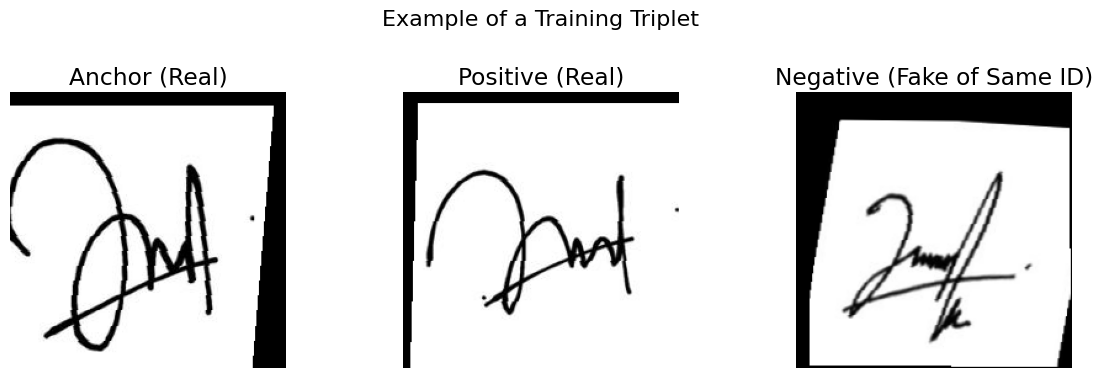

In [10]:
# Visualize a random triplet from the training dataloader.
helper_utils.show_random_triplet(train_dataloader)

### Constructing the Siamese Network

Now that your data is ready, it's time to build the model. Constructing a Siamese Network involves two key parts: first, you'll build a core "backbone" network to extract features from the signatures, and second, you'll create the *main* Siamese model that uses this backbone to compare the images in a triplet.

#### Building the Backbone: The Embedding Network

At first glance, the network you are about to define, `SimpleEmbeddingNetwork`, will look very familiar. It's a standard Convolutional Neural Network (CNN), much like others you may have built for image classification tasks.

However, there is a pivotal difference in its final purpose. Instead of classifying an image into a predefined category (like 'cat' or 'dog'), this network's job is to distill a signature's unique characteristics into a dense numerical vector called an **embedding**.

This changes how you think about the final layer. Instead of an output with a neuron for each class, you have an output that produces a vector of a specific size. This size, which you'll define as the **embedding dimension**, replaces the concept of the 'number of classes'.

This `SimpleEmbeddingNetwork` is the most important piece of the puzzle. It acts as the backbone, or the core feature extractor. The full Siamese Network, which you'll define next, is a simple wrapper that uses this backbone to process all three images in a triplet, ensuring each signature is analyzed in the exact same way to produce a comparable embedding.

* Define the `SimpleEmbeddingNetwork` model class.

In [11]:
class SimpleEmbeddingNetwork(nn.Module):
    """
    A simple Convolutional Neural Network to generate a fixed-size embedding from an image.
    This network is designed for 224x224 RGB input images.

    Attributes:
        conv (nn.Sequential): The convolutional layers for feature extraction.
        fc (nn.Sequential): The fully connected layers for generating the embedding.
    """
    def __init__(self, embedding_dim=128):
        # Initialize the parent nn.Module class.
        super(SimpleEmbeddingNetwork, self).__init__()
        
        # Define the convolutional layers that act as a feature extractor.
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            # Add a dropout layer for regularization to prevent overfitting.
            nn.Dropout(0.4),
            nn.Conv2d(32, 64, kernel_size=5), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            # Add another dropout layer.
            nn.Dropout(0.4),
            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2, stride=2)
        )
        
        # Define the fully connected layers that produce the final embedding vector.
        self.fc = nn.Sequential(
            # The input size is derived from the output of the final conv layer.
            nn.Linear(128 * 25 * 25, 256), nn.ReLU(),
            # Use a dropout layer with a higher rate for stronger regularization.
            nn.Dropout(0.6),
            # The final linear layer maps the features to the desired embedding dimension.
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input batch of images.

        Returns:
            torch.Tensor: The output embedding vector for each image in the batch.
        """
        # Pass the input through the convolutional feature extractor.
        x = self.conv(x)
        # Flatten the 3D feature map into a 1D vector for each item in the batch.
        x = x.view(x.size(0), -1) 
        # Pass the flattened vector through the fully connected layers.
        x = self.fc(x)
        # Return the final embedding.
        return x

#### Assembling the Siamese Network

With your `SimpleEmbeddingNetwork` backbone defined, you will now create the main `SiameseNetwork` class. This class acts as a high level wrapper, and its design is centered around **modularity**.

* **Interchangeable Backbone**: The class is built to accept any embedding network you provide. This allows you to easily swap your `SimpleEmbeddingNetwork` for a different, more powerful backbone later without having to change this main wrapper class.
* **Flexible Inputs**: This modular design also applies to the data it can process. The `forward` method is built to handle both:
    * **Triplets**, by taking an Anchor, Positive, and Negative image and returning three embeddings for your signature verification task. By default, the network expects triplets.
    * **Pairs**, by taking two images and returning two embeddings. You'll see an example of this pair based comparison in a later section within this notebook.

* Define the `SiameseNetwork` class.

In [12]:
class SiameseNetwork(nn.Module):
    """
    A flexible Siamese Network that can process either image triplets or pairs.

    This network uses a shared backbone (embedding network) to generate feature
    vectors (embeddings) for multiple input images simultaneously. It can operate
    in two modes: one for training with triplets (anchor, positive, negative)
    and one for inference with pairs.

    Attributes:
        embedding_network (nn.Module): The shared backbone network.
    """
    def __init__(self, embedding_network):
        """
        Initializes the Siamese Network.
        
        Args:
            embedding_network (nn.Module): The backbone network that generates embeddings.
        """
        # Initialize the parent nn.Module class.
        super().__init__()
        # Store the shared backbone model.
        self.embedding_network = embedding_network
        
    def forward(self, *inputs, triplet_bool=True):
        """
        Processes either a triplet or a pair of images through the embedding network.

        Args:
            *inputs: A sequence of input tensors.
                     - If triplet_bool is True, expects (anchor, positive, negative).
                     - If triplet_bool is False, expects (image1, image2).
            triplet_bool (bool): If True, operates in triplet mode for training.
                                 If False, operates in pair mode for inference.
        
        Returns:
            tuple: A tuple of output embedding tensors.
        """
        if triplet_bool:
            # Handle the case for training with triplets.
            if len(inputs) != 3:
                raise ValueError("In triplet mode, expected 3 inputs: anchor, positive, negative.")
            
            # Unpack the triplet inputs.
            anchor, positive, negative = inputs
            
            # Generate embeddings for each image using the shared backbone.
            anchor_output = self.embedding_network(anchor)
            positive_output = self.embedding_network(positive)
            negative_output = self.embedding_network(negative)
            
            return anchor_output, positive_output, negative_output
        
        else:
            # Handle the case for inference with image pairs.
            if len(inputs) != 2:
                raise ValueError("In pair mode, expected 2 inputs: before_img, after_img.")
            
            # Unpack the pair inputs.
            img1, img2 = inputs
            
            # Generate embeddings for both images using the shared backbone.
            output1 = self.embedding_network(img1)
            output2 = self.embedding_network(img2)
            
            return output1, output2
    
    def get_embedding(self, image):
        """
        Generates a single embedding for a given image.
        
        Args:
            image (torch.Tensor): A single image tensor.

        Returns:
            torch.Tensor: The resulting embedding vector.
        """
        # Pass the single image through the backbone to get its embedding.
        return self.embedding_network(image)

* Now, set the `embedding_dim`. This is a key hyperparameter that defines the size of the numerical vector the model will use to represent each signature.
* Next, create an instance of your backbone, the `SimpleEmbeddingNetwork`, passing in the embedding dimension you just defined.
* Finally, assemble the complete model by creating an instance of the `SiameseNetwork` and passing your `embedding_net` into it as its "backbone".

In [13]:
# Define the desired size for the final embedding vector
embedding_dim = 128

# Create an instance of the base model that generates embeddings
embedding_net = SimpleEmbeddingNetwork(embedding_dim=embedding_dim)

# Create the main Siamese network model, using the embedding network
siamese_network = SiameseNetwork(embedding_network=embedding_net)

### Teaching the Network to See Similarity

With your model architecture and data loaders prepared, you are ready to define the core components for the training.

#### Measuring Similarity: The Triplet Margin Loss

A traditional classifier learns to assign a fixed label to an image. Your goal is different. You need to teach your model how to create an **embedding space**—a virtual map where similar signatures are grouped closely together and forgeries are pushed far away. To sculpt this space, you need a specialized tool, and that's where **Triplet Margin Loss** comes in.

This loss function works by analyzing the three images in a triplet. Its objective is simple but powerful:

> The distance between the **Anchor** and the **Positive** should be smaller than the distance between the **Anchor** and the **Negative**, by at least a certain **margin**.

Think of the **margin** as a "safety buffer." It's not enough for the forgery's distance to be slightly larger than the genuine one's. The loss function demands a clear separation, forcing the model to be decisive. This "common sense" rule can be written as:

> `distance(Anchor, Positive) + margin < distance(Anchor, Negative)`

When the model produces embeddings that satisfy this rule for a given triplet, the loss is zero, and no update is needed. If the rule is violated, the model is penalized, and its weights are adjusted to better separate the embeddings.

#### The Mathematical Formula

Mathematically, this process is captured in the following formula. Here, $f(A)$, $f(P)$, and $f(N)$ represent the embedding vectors your network creates. Let's define the squared Euclidean distance between the anchor and positive as $d(A, P)^2 = ||f(A) - f(P)||^2$.

The loss function is then:

$$L = \max(0, d(A, P)^2 - d(A, N)^2 + \text{margin})$$

The $\max(0, ...)$ function ensures that no loss is incurred if the distance to the negative, $d(A, N)$, is already greater than the distance to the positive, $d(A, P)$, by at least the margin. This allows the model to focus only on misclassified triplets.

Fortunately, you don't need to implement this from scratch. PyTorch provides a highly optimized, pre-built version, <code>[nn.TripletMarginLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)</code>, that you can use directly.

* Define the `TripletMarginLoss` loss function.
    * `margin=1.0`: This sets the "safety margin" to 1.0. Your model will be penalized unless the distance to the negative example is at least 1.0 greater than the distance to the positive example.
    * `p=2`: This specifies that the distance between signatures will be calculated using the L2 norm, which is the standard **Euclidean distance**.

In [14]:
# Initialize the Triplet Margin Loss function
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

#### Optimizer and Scheduler

* Initialize the `AdamW` optimizer with an initial learning rate of `1e-3`.
* Define a `StepLR` learning rate scheduler that will decrease the learning rate by a factor of 10 every 2 epochs.

In [15]:
# Initialize the AdamW optimizer to update the model's weights
optimizer_siamese = optim.AdamW(siamese_network.parameters(), lr=1e-3)

# Set step_size=2 and gamma=0.1 to decrease the LR by a factor of 10 every 2 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer_siamese, step_size=2, gamma=0.1)

#### Orchestrating the Training Process

With all the components prepared, you are ready to train your network. You will use the helper function, `training_loop_signature`, that orchestrates the entire process from start to finish. This function handles training on triplets, validates the model's performance after each epoch, and saves the best version of your model.

Here are the key techniques the function uses:
* **Training on Triplets**: For each step in a training epoch, the function feeds the model a batch of triplets. It unpacks the **Anchor**, **Positive**, and **Negative** images, generates three separate embeddings, and uses the `TripletMarginLoss` to calculate the loss and update the model's weights.

* **Validating with a Threshold**: After training, the function switches to evaluation mode. Since the model outputs a distance, not a class label, accuracy is measured using a **threshold**. This value acts as your decision boundary:
    * A genuine pair (Anchor-Positive) is correct if its distance is **less than** the threshold.
    * A forgery pair (Anchor-Negative) is correct if its distance is **greater than or equal** to the threshold.
    
**A Note on Threshold vs. Margin**: It's important to distinguish between the `margin` (a hyperparameter of the `TripletMarginLoss` function) that teaches the model to create a clear separation during **training**, and the `threshold`, which is the decision boundary used during **evaluation/validation**. For best performance, the `margin` is set higher than the optimal `threshold` to ensure a clear gap is created for making accurate classifications.

In [ ]:
### Uncomment and execute the line below if you wish to see the source code for the training function.

# training_functions.display_code(training_functions.training_loop_signature)

* Run the `training_loop_signature` function to begin the process.

You will train the model for 5 epochs. Feel free to experiment with this number, as a range of 5 to 10 epochs is recommended to achieve strong performance on this dataset.

For this task, you will set the validation threshold to `0.8`. In a high-stakes scenario like signature verification, the cost of getting a prediction wrong (accepting a forgery) is very high. A reasonably strict threshold like `0.8` makes it more difficult for a forgery to be accepted, prioritizing security even if it means an occasional genuine signature might be flagged for a second look.

In [16]:
# Define the distance threshold for validation accuracy calculation.
threshold_dist = 0.8

# Execute the main training and validation loop.
trained_siamese = training_functions.training_loop_signature(
    # The Siamese network model instance.
    model=siamese_network,
    # DataLoader for the training set.
    train_loader=train_dataloader,
    # DataLoader for the validation set.
    val_loader=val_dataloader,
    # The triplet margin loss function.
    loss_fcn=triplet_loss,
    # The optimizer for updating model weights.
    optimizer=optimizer_siamese,
    # The learning rate scheduler.
    scheduler=scheduler,
    # The distance threshold for validation accuracy.
    threshold=threshold_dist,
    # The compute device (e.g., 'cpu' or 'cuda').
    device=device,
    # File path to save the best performing model.
    save_path='./saved_models/best_signature_siamese.pth',
    # The total number of epochs for training.
    n_epochs=5
)

--- Starting Training & Validation ---



Epoch 1/5 [Training]:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.1004 | Val Loss: 1.0000 | Val Acc: 50.00% | LR: 0.001000

  -> New best model saved to './saved_models/best_signature_siamese.pth' with Val Acc: 50.00%



Epoch 2/5 [Training]:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.0003 | Val Loss: 1.0000 | Val Acc: 50.00% | LR: 0.001000



Epoch 3/5 [Training]:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.0001 | Val Loss: 1.0000 | Val Acc: 50.00% | LR: 0.000100



Epoch 4/5 [Training]:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.9997 | Val Loss: 1.0000 | Val Acc: 50.00% | LR: 0.000100



Epoch 5/5 [Training]:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 1.0001 | Val Loss: 1.0000 | Val Acc: 50.00% | LR: 0.000010


--- Training & Validation Complete ---
Best model saved to './saved_models/best_signature_siamese.pth' with accuracy 50.00%


### Visualizing Model Predictions

An overall accuracy score is a great metric, but it is also vital to see your model in action on individual examples. This qualitative check helps you build intuition for where the model succeeds and where it might struggle.

* Calculate the distance between the **Anchor-Positive** and **Anchor-Negative** pairs using your trained model.
* Compare these distances against your `threshold_dist` to make a prediction (Genuine or Forgery).

--- Displaying Validation Predictions with Distance Visualization ---



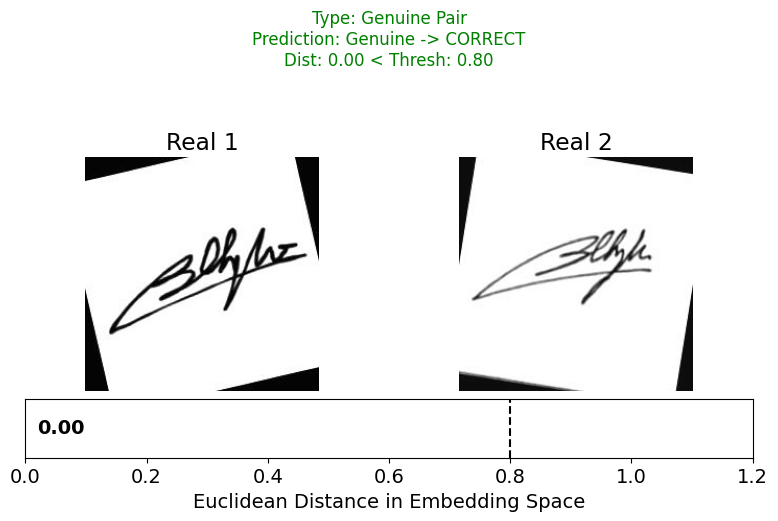

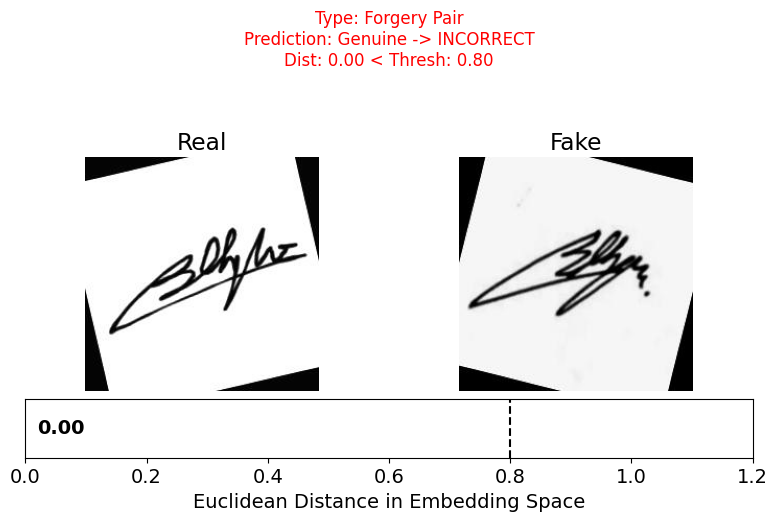

In [17]:
# Visualize the model's performance on a few random triplets from the validation set.
helper_utils.show_signature_val_predictions(
    trained_siamese,
    val_dataloader,
    threshold=threshold_dist,
    device=device
)

### Real-World Application: One-Shot Signature Verification

This is where the true power of a Siamese Network becomes clear. The model has not learned to classify specific signatures; it has learned to create a meaningful *embedding space* where similar signatures are close together and different ones are far apart.

This means you can now verify signatures for individuals the model has **never seen before** without retraining it. Imagine a new customer joins the bank. Instead of needing hundreds of their signatures to retrain the model, you only need **one** trusted, genuine signature on file. This is **one-shot learning**. Any new signature they provide can be compared against that single trusted instance to verify its authenticity. This makes the system incredibly scalable and practical for real-world use at the bank.

To test this one-shot capability, you'll perform a verification for this new, unseen individual. The available sample images for this individual are:

```
./signature_samples/
│
├── Real/
│   ├── real_6_1.jpg
│   ├── real_6_2.jpg
│   ├── real_6_3.jpg
│   └── real_6_4.jpg
│
└── Fake/
    ├── fake_6_1.jpg
    ├── fake_6_2.jpg
    ├── fake_6_3.jpg
    ├── fake_6_4.jpg
    └── fake_6_5.jpg
```

* First, you need to select a trusted reference signature that would be hypothetically kept "on file" at the bank. This will serve as your anchor image.

In [27]:
# Define the path to the real signature image
signature_anchor = "./signature_samples/Real/real_6_1.jpg"

* Next, you will choose a second signature, either another genuine one or a forgery, to test against the reference image.

In [28]:
# Define the path to the signature image to verify
signature_to_verify = "./signature_samples/Fake/fake_6_2.jpg"

With both the trusted 'signature on file' and the signature to be verified now defined, you are ready to see the final result.

* Compare the distance to your `threshold_dist` to make a final verdict: **Genuine** or **Forgery**.

--- Verification Result ---
Distance: 0.0000
Decision Threshold: 0.8000
Prediction: ✅ Genuine Signature



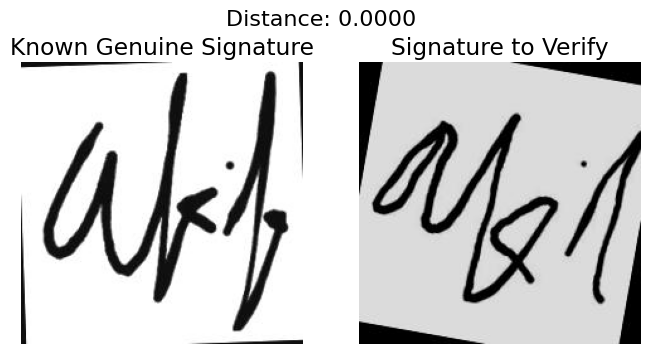

In [29]:
# Perform one-shot verification on the two images
helper_utils.verify_signature(
    model=trained_siamese, 
    genuine_path=signature_anchor, 
    test_path=signature_to_verify, 
    threshold=threshold_dist,
    transform=val_transform, 
    device=device
)

<br>

Excellent work! You have successfully engineered a sophisticated verification system. By teaching a network to measure similarity, you have unlocked the power of one shot learning, creating a model that can validate a signature it has never encountered before. This is a powerful demonstration of what this architecture can achieve.

Now, prepare to pivot. You will take the core concepts you have mastered and apply them to an entirely new challenge: detecting environmental change from satellite imagery. Let's see just how versatile this approach to similarity learning truly is.

## **Use Case 2:** Tracking Environmental *Change*

You've seen how a Siamese Network can master a verification task. Now, you will apply the same core architecture to a powerful new application: **change detection** in satellite imagery. Your goal is to identify significant changes in vegetation by comparing "Before" and "After" images of a location.

For this challenge, you will work with the [LEVIR-CD+](https://www.kaggle.com/datasets/mdrifaturrahman33/levir-cd-change-detection) dataset. While it was originally designed to track changes in buildings, you will creatively repurpose it to focus on a new metric: **the change in greenery**. This exercise mirrors a common real world scenario where you must adapt existing data to solve a novel problem. It's a perfect demonstration of how the fundamental steps for building a similarity model remain consistent across different domains.

**How the Dataset Was Prepared for This Lab**

To tailor the dataset for this task, a custom script automated the curation process. The key steps performed were:

* **Data Augmentation**: The original dataset mostly showed greenery loss due to new construction. To create more balanced examples of Positive and Negative change, the "Before" and "After" images in each pair were randomly swapped 50% of the time.

* **Greenery Calculation**: The script analyzed each image by converting it to the **HSV (Hue, Saturation, Value)** colour space. It then counted every pixel that fell within a specific color range for green to calculate the total percentage of vegetation.

* **Change Categorization**: Based on this simple count of green pixels, each pair was sorted using a 5% change threshold: **Positive** (≥5% gain), **Negative** (≥5% loss), or **No Change** (any change within the -5% to +5% range).

* **Image Resizing**: As a final step in the script, all images were resized to **300x300 pixels** to create a more memory efficient dataset.

The 5% threshold was an arbitrary value chosen for this lab. In your own use cases, you could set this to any number that best defines a "significant" change for your specific problem.

As a reminder, this automated sorting process is not perfect. You will likely encounter some noisy or miscategorized images. This presents a realistic industry challenge, and your goal remains the same: to build a robust model that can learn effectively from imperfect data.

* Run the next cells below to see a statistical overview of your dataset.

In [21]:
# Define the path to the root directory containing the change dataset.
change_data_dir = './levir_cd_plus_simulated/'

In [22]:
# Scan the data directory and display the statistical summary.
helper_utils.display_change_dataset_stats(change_data_dir)

Change Category,Number of Image Pairs
Negative,330
No_Change,314
Positive,332
Total,976


* Run the cell below to visualize a random "Before" and "After" pair from each of the three change categories (`Positive`, `Negative`, and `No_Change`).

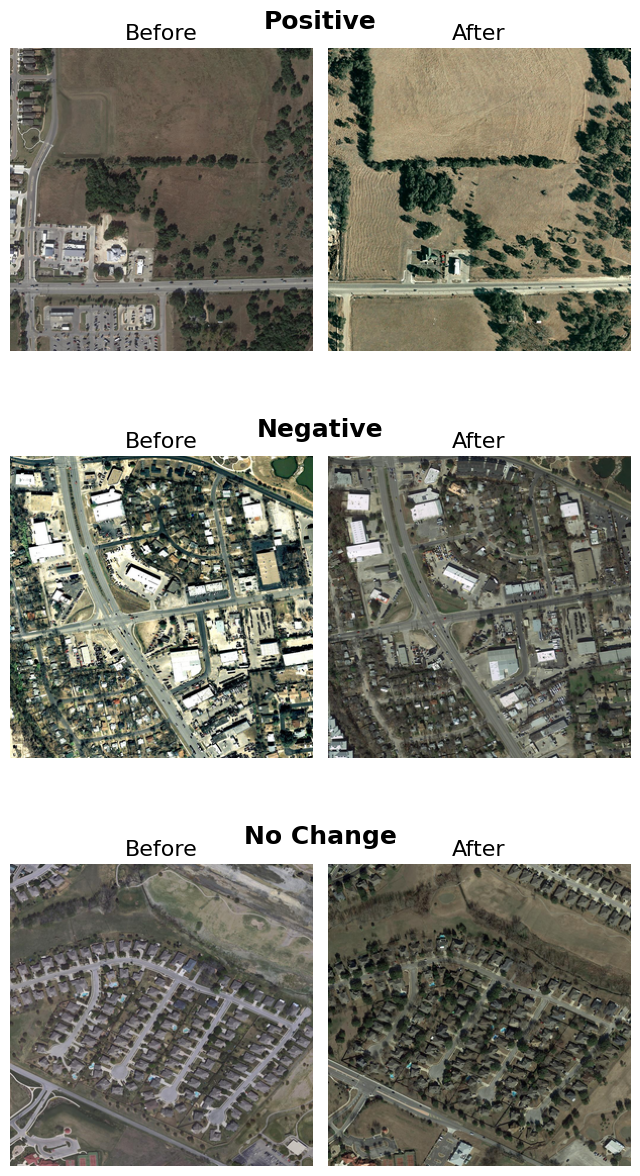

In [23]:
# Display a side-by-side comparison of pairs of each class from the dataset.
helper_utils.display_random_change_pairs(change_data_dir)

### Building the Change Detection Dataset Class

For this new use case, your approach must adapt. Instead of feeding the network **triplets**, you will now work with **pairs** of images. The essential learning unit for your model now becomes a "Before" image, an "After" image, and a label describing the change between them.

To generate these pairs efficiently, the `ChangeDetectionDataset` class is designed for the following directory structure:

```
./levir_cd_plus_simulated/
│
├── Negative/
│   ├── After/
│   │   ├── train_1.png
│   │   └── ... (more 'after' images)
│   │
│   └── Before/
│       ├── train_1.png
│       └── ... (more 'before' images)
│
├── No_Change/
│   ├── After/
│   │   ├── train_1.png
│   │   └── ... (more 'after' images)
│   │
│   └── Before/
│       ├── train_1.png
│       └── ... (more 'before' images)
│
└── Positive/
    ├── After/
    │   ├── train_1.png
    │   └── ... (more 'after' images)
    │
    └── Before/
        ├── train_1.png
        └── ... (more 'before' images)
```

This categorized structure allows the class to load a "Before" image, find its corresponding "After" image, and assign the correct label (`Positive`, `Negative`, or `No_Change`). While it's still a standard PyTorch `Dataset`, its internal logic differs significantly from the triplet class.

Here’s how its main components work:

* **`__init__(self, base_dir, ...)`**: 
> This constructor still performs a **one time** setup scan. However, instead of mapping signatures to individuals, it builds a single, complete list of all valid (`before_path`, `after_path`, `label`) image pairs found across all categories.

* **`__len__(self)`**: 
> This method returns the **actual total number of pairs** in the dataset. Unlike the "virtual" length in the previous class, this is a fixed number determined by the files on disk.

* **`__getitem__(self, index)`**: 
> This is a fundamental change from the triplet dataset. The `__getitem__` method now **uses the `idx` argument** to retrieve a specific image pair and its label from the list created during initialization. There is no on the fly random sampling; it simply fetches the item at the requested index.

* **`_load_image(self, path)`**: 
> This is the same robust, private helper method used before. It ensures each image is loaded correctly and efficiently, using a context manager to prevent resource leaks.

In [ ]:
class ChangeDetectionDataset(Dataset):
    """
    A PyTorch Dataset for loading 'Before' and 'After' image pairs
    for a change detection task.

    This class scans a directory where subdirectories are named
    'Positive', 'Negative', and 'No_Change', each containing 'Before' and
    'After' subfolders with corresponding image pairs.
    """
    def __init__(self, base_dir, transform=None):
        """
        Initializes the dataset by scanning the data directory and organizing file paths.
        
        Args:
            base_dir (str): Path to the root directory which contains the
                            'Positive', 'Negative', and 'No_Change' folders.
            transform (callable, optional): PyTorch transforms to be applied to each image.
        """
        self.base_dir = base_dir
        self.transform = transform
        
        # Define a mapping from class names to integer labels for convenience.
        self.class_to_label = {'Positive': 0, 'Negative': 1, 'No_Change': 2}
        
        # Build the complete list of all available image pairs from the source directory.
        self.image_pairs = self._create_image_pairs()
        
        # Raise an error if the dataset directory is empty or improperly structured.
        if not self.image_pairs:
            raise RuntimeError(f"No valid image pairs found in {base_dir}. Check directory structure.")

    def _create_image_pairs(self):
        """Scans the directory to build a list of (before_path, after_path, label) tuples (one-time setup)."""
        image_pairs = []
        # Iterate through each change category ('Positive', 'Negative', 'No_Change').
        for class_name, label in self.class_to_label.items():
            class_dir = os.path.join(self.base_dir, class_name)
            before_dir = os.path.join(class_dir, 'Before')
            after_dir = os.path.join(class_dir, 'After')
            
            # Skip this category if its 'Before' directory does not exist.
            if not os.path.isdir(before_dir):
                continue

            # Iterate through all files in the 'Before' directory.
            for filename in os.listdir(before_dir):
                if filename.lower().endswith(('.png', '.jpg')):
                    # Construct the full paths for the 'Before' and corresponding 'After' images.
                    before_path = os.path.join(before_dir, filename)
                    after_path = os.path.join(after_dir, filename)
                    
                    # Add the pair to the list only if the corresponding 'After' image exists.
                    if os.path.exists(after_path):
                        image_pairs.append((before_path, after_path, label))
        return image_pairs

    def __len__(self):
        """Returns the total number of image pairs in the dataset."""
        return len(self.image_pairs)

    def __getitem__(self, idx):
        """
        Generates and returns one pair of images and its corresponding label.
        
        Args:
            idx (int): The index of the image pair to retrieve from the dataset.
            
        Returns:
            tuple: A tuple containing (before_img, after_img, label).
        """
        # Retrieve the file paths and label for the requested index.
        before_path, after_path, label = self.image_pairs[idx]
        
        # Load the 'before' and 'after' images from their respective paths.
        before_img = self._load_image(before_path)
        after_img = self._load_image(after_path)
            
        return before_img, after_img, label
        
    def _load_image(self, path):
        """
        Helper function to robustly load a single image from a given path.

        Args:
            path (str): The file path of the image to load.

        Returns:
            The loaded and transformed image, typically a torch.Tensor.
        """
        # Use a context manager to ensure the file is properly closed after loading.
        with Image.open(path) as img:
            # Ensure the image is in RGB format, as many networks expect 3 channels.
            image = img.convert("RGB")
            # Apply any specified transformations (e.g., resizing, tensor conversion).
            if self.transform:
                image = self.transform(image)
        return image

* Now that your `ChangeDetectionDataset` class is defined, create the main dataset object.

In [ ]:
# Initialize the full dataset object. 
full_change_dataset = ChangeDetectionDataset(change_data_dir)

### Preparing the Change Data for Training

* First, define your pipelines of transformations for training and validation data.
    * Because you will be using a model that was pre-trained on the ImageNet dataset, it is essential to normalize your images using the standard ImageNet `mean` and `std` values.

In [ ]:
# ImageNet normalization statistics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Transformations for validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

* Now, you will split the main dataset and prepare the final `DataLoaders` for training.
    * Divide the full dataset into an 80% training set and a 20% validation set.
    * Create dataloaders for each set to handle batching and shuffling.

In [ ]:
# Split the full dataset into training and validation sets.
train_dataset, val_dataset = helper_utils.create_change_datasets_splits(
    full_dataset=full_change_dataset,
    train_split=0.8, 
    train_transform=train_transform,
    val_transform=val_transform
)

# Create a DataLoader for the training set.
train_dataloader_change = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Create a DataLoader for the validation set.
val_dataloader_change = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the final "virtual" size of each dataset split.
print(f"Total training pairs: {len(train_dataset)}")
print(f"Total validation pairs: {len(val_dataset)}")

### Visualizing a Training Sample

* Visualize a random sample to confirm everything is working as expected.
    * Since the training data uses augmentations like random rotation and flipping, the images will appear transformed. While they might seem slightly misaligned or different, be assured that they are the correct "Before" and "After" pair of the same location.

In [ ]:
# Visualize a random pair from the training dataloader.
helper_utils.show_random_pair(train_dataloader_change)

### A New Backbone for a New Challenge

Remember the modular `SiameseNetwork` wrapper you built earlier? Its flexible design, which allows for an interchangeable backbone and can process image pairs, is about to pay off. You can reuse that main network class without any changes.

For this more complex satellite imagery task, you will upgrade the backbone. Instead of the simple CNN from the first use case, you will use a powerful, pre-trained [EfficientNet](https://docs.pytorch.org/vision/main/models/efficientnet.html) model.

You will load the pre-trained weights and prepare the model for **fine-tuning**, where all of its layers will be trained. The modification process is one you are already familiar with: you will replace the model's final classifier head. As you saw before, instead of swapping it for a layer with a set number of classes, you will replace it with a linear layer that outputs a vector of your desired **embedding dimension**.

* Load the **EfficientNet** embedding network.

In [ ]:
# Create the EfficientNet-based embedding network
efficientnet_embedding = helper_utils.get_efficientnet_embedding_backbone(embedding_dim=128)

* Now, assemble your complete model by passing the `efficientnet_embedding` network into the main `SiameseNetwork` wrapper.

In [ ]:
# Instantiate the main Siamese model, using the EfficientNet network as its base
siamese_efficientnet = SiameseNetwork(embedding_network=efficientnet_embedding)

### Teaching the Network to Detect Change

With your model and data ready, the next step is to define the loss function and optimizer. For this task, the process is slightly different from the first use case because you must account for the imbalanced nature of your dataset.

#### Addressing Class Imbalance

You may have noticed that for the first use case, Signature Verification, you did not explicitly handle class imbalance. This is because that model was trained with **Triplet Loss**, which focuses on learning the relative distances between images in an embedding space. Its goal was not to classify an image into a specific category, so the number of examples per individual was less of a concern.

For this Change Detection task, however, handling class imbalance is an **essential** step. Your dataset is divided into three distinct classes (`Positive`, `Negative`, `No_Change`) that have a different number of examples. If you ignore this, the model will become biased towards the most common class and will perform poorly on the rare but important change events. By calculating and using class weights, you force the model to pay more attention to the under represented classes, leading to a more balanced and useful result.

* Run the cell below to compute the specific weights for each class in your training data.

In [ ]:
# Compute the class weights using the full and train datasets.
class_weights = helper_utils.compute_change_class_weights(
    train_dataset=train_dataset,
    full_untransformed_dataset=full_change_dataset
)

# Print class weights
label_to_class = {v: k for k, v in full_change_dataset.class_to_label.items()}
for i, weight in enumerate(class_weights):
    print(f"Class '{label_to_class[i]}': Weight = {weight:.4f}")

#### The Weighted Contrastive Loss

For your first task, `TripletMarginLoss` was the perfect tool because your objective was to compare relative distances within a set of three images. Now, your goal has shifted. You are working with labeled **pairs** of images and must also account for class imbalance. This requires a new loss function designed for this specific challenge: the `WeightedContrastiveLoss`.

This function is based on the principles of **Contrastive Loss**, which is designed specifically for learning from pairs. It elegantly adapts your three class problem (`Positive`, `Negative`, `No_Change`) into a binary similarity task:

* **Similar Pairs** (labeled as `No_Change`): For these pairs, the loss function encourages the model to produce embeddings that are extremely close together, minimizing their distance.
* **Dissimilar Pairs** (labeled as `Positive` or `Negative`): For these pairs, the loss function demands a clear separation. It pushes their embeddings far apart by enforcing a minimum **margin**.

The most important component, however, is the "Weighted" aspect. The final loss calculated for each pair is multiplied by the class weight you computed earlier. This ensures that a mistake made on a rare class (like `Positive` change) is penalized more heavily, compelling your model to learn to detect these infrequent but important events effectively.

#### The Mathematical Formula

Let's break down how this works. The function first calculates the standard Euclidean distance between the two embeddings, $d = ||f(I_1) - f(I_2)||$. It then uses a binary label, $y$, where $y=0$ for a similar pair (`No_Change`) and $y=1$ for a dissimilar pair (`Positive` or `Negative`).

The standard contrastive loss is then calculated as:

$$L_{contrastive} = (1-y) \cdot d^2 + y \cdot \max(0, \text{margin} - d)^2$$

This formula has two distinct parts that work in opposition:
* If the pair is **similar** ($y=0$), the second term disappears. The loss becomes $L = d^2$. The model is penalized for *any* distance between the embeddings, pushing it to make them identical.
* If the pair is **dissimilar** ($y=1$), the first term disappears. The loss becomes $L = \max(0, \text{margin} - d)^2$. The model is only penalized if the distance $d$ is *less than* the margin, forcing it to create a clear separation.

Finally, to create the weighted loss, this result is scaled by the class weight, $w$:

$$L_{weighted} = w \cdot L_{contrastive}$$

This final step ensures that the updates to your model's parameters are appropriately influenced by the rarity of each class, creating a more balanced and accurate final model.

> 💡 **A 3-Class Dataset for a 2-Class Loss?**
>
> You might be wondering: why did you go to the trouble of preparing a dataset with three classes (`Positive`, `Negative`, `No_Change`), only to use a loss function that simplifies this into a binary problem ("Change" vs. "No Change")? And if it's a binary problem, what happens to the three class weights you just calculated?
>
> This is a deliberate and powerful strategy. The loss function works in two stages. First, it simplifies the comparison to a binary one: is the pair *similar* (`No_Change`) or *dissimilar* (`Positive` or `Negative`)? After calculating a preliminary loss based on this, it looks back at the **original three class label** and applies the specific weight for that class. So, a `Positive` pair's loss is scaled by the `Positive` weight, and a `Negative` pair's loss is scaled by the `Negative` weight.
>
> By doing this, you are not teaching the model to be a **classifier** that sorts image pairs into three rigid buckets. Instead, you are teaching it to be a **distance metric**, like a very intelligent ruler. The output is not a simple category, but a meaningful **distance score**. A small distance means "no change," and a large distance means "significant change."
>
> This is the key advantage. In the next sections, you will see how you can analyze all the distance scores from your validation set to find an **optimal distance threshold**. This gives you the power to tune the model's sensitivity after it has been trained, which is a huge benefit compared to using `CrossEntropyLoss` directly. This distance based method often provides more flexibility and control over the final decision making process.

* Define the `WeightedContrastiveLoss` loss function.

In [ ]:
class WeightedContrastiveLoss(nn.Module):
    """
    A contrastive loss function that incorporates class weights to handle imbalance.
    
    It adapts a multi-class problem into a binary similarity problem where
    'No_Change' is 'similar' and 'Positive'/'Negative' are 'dissimilar'.
    """
    def __init__(self, device, margin=1.0, class_weights=None):
        """
        Initializes the weighted contrastive loss function.
        
        Args:
            device (torch.device): The device to move class weights to.
            margin (float): The margin for dissimilar pairs.
            class_weights (torch.Tensor, optional): A tensor of weights for each class.
                                                      Shape: (num_classes,).
        """
        super().__init__()
        self.margin = margin
        self.device = device
        
        # Move weights to the correct device once during initialization for efficiency.
        if class_weights is not None:
            self.class_weights = class_weights.to(self.device)
        else:
            self.class_weights = None

    def forward(self, output1, output2, label):
        """
        Computes the weighted contrastive loss for a batch of embeddings.

        Args:
            output1 (torch.Tensor): Embeddings for the first set of images.
            output2 (torch.Tensor): Embeddings for the second set of images.
            label (torch.Tensor): The multi-class labels (0, 1, or 2) from the dataset.
        """
        # Calculate the pairwise Euclidean distance between the output embeddings.
        distances = F.pairwise_distance(output1, output2)
        
        # Convert multi-class labels (0, 1, 2) to binary similarity labels (1, 1, 0).
        # A label of 2 ('No_Change') is considered similar (0), others are dissimilar (1).
        binary_label = (label != 2).float()

        # Calculate the contrastive loss for each sample in the batch.
        loss_per_sample = (
            # Loss for similar pairs aims to minimize the distance.
            (1 - binary_label) * distances.pow(2) +
            # Loss for dissimilar pairs aims to make the distance larger than the margin.
            binary_label * torch.clamp(self.margin - distances, min=0).pow(2)
        )

        # Apply class-specific weights to the loss if they are provided.
        if self.class_weights is not None:
            # Gather the correct weight for each sample using its original multi-class label.
            weights = self.class_weights[label.long()]
            
            # Multiply each sample's loss by its corresponding class weight.
            loss_per_sample = loss_per_sample * weights
            
        # Return the mean of the (potentially weighted) losses for the batch.
        return loss_per_sample.mean()

* Initialize your custom `WeightedContrastiveLoss` function.
    * `margin=2.0`: This sets the desired separation distance for dissimilar pairs (Positive or Negative change).
    * `class_weights=class_weights`: You pass the `class_weights` tensor you calculated earlier, which allows the loss function to counteract class imbalance.
    * `device=device`: This ensures that the class weights tensor is moved to the correct compute device (e.g., your GPU).

In [ ]:
# Initialize the custom weighted contrastive loss function with the calculated class weights.
contrastive_loss = WeightedContrastiveLoss(margin=2.0, class_weights=class_weights, device=device)

#### Optimizer and Scheduler

For this task, you'll use a more dynamic learning rate scheduler that can adapt to the model's performance during training.

* Initialize the `AdamW` optimizer with an initial learning rate of `1e-3`.
* Define a `ReduceLROnPlateau` scheduler. This scheduler will monitor the validation loss and automatically reduce the learning rate when it stops improving.
    * It will wait for **2 full epochs** (`patience=2`) of no improvement before reducing the learning rate.
    * When triggered, it will reduce the learning rate by a **factor of 0.2** (`factor=0.2`).

In [ ]:
# Initialize the AdamW optimizer for the new EfficientNet-based model
optimizer_change = optim.AdamW(siamese_efficientnet.parameters(), lr=1e-3)

# Initialize the new, more flexible scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_change,
    mode='min',      # Reduce LR when the validation loss stops decreasing
    factor=0.2,      # New LR = LR * factor
    patience=2,      # Wait 2 epochs with no improvement before reducing LR
)

#### Orchestrating the Training Process

With all the components prepared, you are ready to train your new network. You will use the `training_loop_change` function, which orchestrates the entire process. The key difference in this approach is a strategic one: unlike the signature task where you used a predefined threshold for validation, this loop's only goal is to find the model that achieves the **lowest validation loss**.

This two step process is more flexible and stands in contrast to the previous method. For a **high stakes task** like signature verification, you provided a fixed threshold during validation. This approach gives you more **direct control**, forcing the model to create an embedding space tailored to your specific decision boundary.

Here, the strategy is more exploratory. You first let the model train to create the best possible embedding space. **Only after training is complete** will you perform a separate evaluation to find the data driven **optimal threshold** that yields the best performance. While this means you do not predefine the final threshold value, separating the act of learning features from making a final decision often leads to a more robust result. Both techniques are valid, and the best choice depends on the requirements of your task.

Here's a breakdown of how the function works:

* **Training on Pairs**: For each step in a training epoch, the function feeds the model a batch of ("Before" image, "After" image, label) pairs. It generates two embeddings and uses the `WeightedContrastiveLoss` to calculate the loss and update the model's weights.

* **Validating on Loss**: The function's sole purpose in the validation phase is to measure the average loss on the validation set. The model that achieves the lowest validation loss is considered the best, as this indicates it has learned the most effective embedding space.

In [ ]:
### Uncomment and execute the line below if you wish to see the source code for the training function.

# training_functions.display_code(training_functions.training_loop_change)

* You will train the model for 10 epochs. Feel free to experiment with this number, as a range of 10 to 15 epochs is recommended to achieve strong performance on this dataset.

In [ ]:
# Run the training process
trained_efficientnet = training_functions.training_loop_change(
    # The Siamese network model built on EfficientNet.
    model=siamese_efficientnet,
    # DataLoader for the training set.
    train_loader=train_dataloader_change,
    # DataLoader for the validation set.
    val_loader=val_dataloader_change,
    # The weighted contrastive loss function.
    loss_fcn=contrastive_loss,
    # The optimizer for updating model weights.
    optimizer=optimizer_change,
    # The learning rate scheduler.
    scheduler=scheduler,
    # The compute device (e.g., 'cpu' or 'cuda').
    device=device,
    # File path to save the model with the lowest validation loss.
    save_path='./saved_models/best_change_siamese.pth',
    # The total number of epochs for training.
    n_epochs=10
)

#### Finding the Optimal Threshold

Your model has now been trained to create a meaningful embedding space by focusing on a single goal: minimizing validation loss. As promised, it is now time for the second step of your strategy: turning the model's raw distance outputs into concrete, accurate decisions.

The `evaluation_loop` function is designed for this specific purpose. Its job is to analyze all the distances your trained model produces for the validation set and find the single **optimal distance threshold** that best separates "Change" from "No Change" pairs.

Here is a summary of its methodical approach:

* Collect All Distances and Labels
* Test Candidate Thresholds
* Calculate Accuracy for Each Threshold
* Identify and Return the Best Threshold

This process will give you the optimal decision boundary for this model, which you can then use to make predictions on new data.

In [ ]:
### Uncomment and execute the line below if you wish to see the source code for the avaluation function.

# training_functions.display_code(training_functions.evaluation_loop)

In [ ]:
# Evaluate the model that was trained
optimal_threshold = training_functions.evaluation_loop(
    # Your fine-tuned EfficientNet Siamese model.
    model=trained_efficientnet,
    # The DataLoader for the change detection validation set.
    data_loader=val_dataloader_change,
    # The same weighted contrastive loss used during training.
    loss_fcn=contrastive_loss,
    # The compute device (e.g., 'cpu' or 'cuda').
    device=device
)

### Seeing Your Model in Action

Excellent work. You have successfully trained a powerful embedding model and used a data-driven approach to find its optimal decision threshold. With these two key components, your change detection system is now complete.

It is time to put it all together and see your model in action. First, you will perform a full quantitative evaluation using a **classification report** and **confusion matrix** to get a clear picture of your model's overall performance. Then, you will visualize individual predictions to get a more qualitative feel for its decisions. Finally, you will apply your complete system to a new, unseen pair of images, simulating a real-world prediction from start to finish.

* Perform a full quantitative evaluation by generating a classification report and a confusion matrix for your model's performance on the validation set.

In [ ]:
# Call the function with your trained model, validation loader, and optimal threshold
helper_utils.plot_confusion_matrix_and_metrics(
    model=trained_efficientnet,
    data_loader=val_dataloader_change,
    threshold=optimal_threshold,
    device=device
)

#### A Two-Step Approach Prediction

Now for the interesting part: how do you get a three class prediction (`Positive`, `Negative`, `No Change`) from a model that was trained for a binary task ("Change" vs. "No Change")? 

You will use a powerful and common two step approach.

**First**, your Siamese network acts as the primary change detector. It learned to be a **distance metric**, not a classifier. It uses the **optimal threshold** you found to make one simple decision: *has a significant change occurred?*

The rule is straightforward: any distance calculated by the model that is **at or below** this threshold is classified as "No Change." Any distance **above** the threshold is flagged as a "Change" and passed to the next step.

**Second**, *only if the model flags a "Change"*, you apply a simple heuristic to determine the *type* of change. This is a common and powerful approach in many applications. For this lab, the heuristic is the same **HSV color analysis** logic that was used to create the original dataset labels (a greater than **5% increase or decrease** in greenery). In your own use cases, you could substitute this with any set of logical rules that fit your specific problem.

This is a valid technique, not a shortcut. Your Siamese network was **never trained on the color analysis data**; it learned from raw pixels alone to identify complex visual changes. The color analysis is just an efficient, separate rule applied after the model has done the difficult work.

* Run the cell below to see this two step prediction process in action on a random sample from each class.

In [ ]:
# Visualize the model's performance on a few random samples from the validation set.
helper_utils.show_change_val_predictions(
    model=trained_efficientnet,
    val_loader=val_dataloader_change,
    model_threshold=optimal_threshold,
    device=device
)

#### Real-World Application: Predicting Change on Unseen Data

This is the final test for your complete system, which consists of your trained model and the optimal threshold. Your model has not memorized specific locations; instead, it has learned the general visual characteristics of what constitutes a significant change in greenery. Now you will see if it can apply that knowledge to a pair of images it has **never encountered before**.

This tests the model's ability to **generalize** its knowledge to new locations. This is an essential test for any production model: proving it can perform reliably on new, unseen data from the same domain. To perform this test, you may use the following set of sample pair images that were held out from all training and validation:

```
./change_samples/
│
├── Negative/
│   ├── After/
│   │   ├── train_160.png
│   │   ├── train_502.png
│   │   └── train_944.png
│   │
│   └── Before/
│       ├── train_160.png
│       ├── train_502.png
│       └── train_944.png
│
├── No_Change/
│   ├── After/
│   │   ├── train_1.png
│   │   ├── train_241.png
│   │   └── train_523.png
│   │
│   └── Before/
│       ├── train_1.png
│       ├── train_241.png
│       └── train_523.png
│
└── Positive/
    ├── After/
    │   ├── train_25.png
    │   ├── train_624.png
    │   └── train_803.png
    │
    └── Before/
        ├── train_25.png
        ├── train_624.png
        └── train_803.png
```

* First, you will define the path to the "Before" image you want to analyze.

In [ ]:
# Define the path to the "before" image
before_image = "./change_samples/Positive/Before/train_803.png"

* Next, you will define the path for the corresponding "After" image.

In [ ]:
# Define the path to the "after" image
after_image = "./change_samples/Positive/After/train_803.png"

* Finally, you will run the prediction function to get a final verdict from your complete system.

In [ ]:
# Visualize the model's performance on a unseen sample pairs.
helper_utils.predict_greenery_change(
    model=trained_efficientnet, 
    before_path=before_image, 
    after_path=after_image, 
    model_threshold=optimal_threshold, 
    transform=val_transform, 
    device=device
)

## Conclusion

Congratulations! You have successfully navigated the fascinating world of similarity learning, building a complete and powerful system from the ground up. You have seen firsthand how a single, elegant architecture, the Siamese Network, can be adapted to solve two completely different and complex real-world problems.

Throughout this lab, you have moved beyond traditional classification and mastered the art of teaching a model to understand similarity. You constructed a **modular Siamese Network** with an interchangeable backbone, then applied it to a security task by training it for **one shot signature verification** using `TripletMarginLoss`. You then pivoted to solve an environmental challenge, adapting your model with a **pre-trained backbone** and a custom `WeightedContrastiveLoss` to handle class imbalance. Finally, you explored **advanced evaluation strategies** and implemented a hybrid prediction system, combining your deep learning model with a logical heuristic.

The skills you've developed here are incredibly versatile. The ability to measure similarity is at the heart of many advanced AI applications, such as face recognition, content recommendation systems, and plagiarism or duplicate detection.

You now have the tools and the strategic understanding to apply similarity learning to your own unique challenges. Well done!